In [ ]:
!pip install d2l==1.0.0a1.post0

In [2]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os

import joblib as jb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l
from torch import nn
from torchmetrics import R2Score
from torchsummary import summary

In [5]:

class _SepConv1d(nn.Module):
    """A simple separable convolution implementation.

    The separable convlution is a method to reduce number of the parameters 
    in the deep learning network for slight decrease in predictions quality.
    """

    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(
            ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))


In [6]:
class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.

    The module adds (optionally) activation function and dropout layers right after
    a separable convolution layer.
    """

    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):

        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


In [7]:

class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)


In [49]:

class Classifier(nn.Module):
    def __init__(self, raw_ni, no, drop=.5):
        super().__init__()

        self.net = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(raw_ni, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, no),
        )

    def forward(self, x):
        out = self.net(x)
        return out


In [50]:
# Calculating the loss
# loss = nn.CrossEntropyLoss(reduction='none')
loss = nn.MSELoss(reduction='none')


def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return l_sum / n


In [51]:
def loss_plotter(train_losses,test_losses):
    plt.figure(figsize = (10,6) )
    plt.plot(train_losses, 'r*-', label = "Train Loss")
    plt.plot(test_losses, 'b*-', label = "Test Loss")
    plt.legend()
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("The Loss Value")
    
    

In [52]:
spo2_vals = jb.load('strided_dataset_spo2_vals.pk')

In [53]:
stride_dataset = jb.load('strided_dataset.pk')

In [54]:
dataset = pd.DataFrame.from_dict(stride_dataset).transpose()


In [55]:
dataset_spo2 = pd.DataFrame.from_dict(spo2_vals).transpose()

In [56]:
dataset_spo2 = dataset_spo2/100

In [57]:
X_train, X_valid, X_test = np.split(dataset.sample(
    frac=1), [int(.8*len(dataset)), int(.9*len(dataset))])
y_train, y_valid, y_test = dataset_spo2.loc[X_train.index], dataset_spo2.loc[
    X_valid.index], dataset_spo2.loc[X_test.index]


In [58]:
# unroll the data
X_train_unrolled = []
y_train_unrolled = []
for r in X_train.index:
    for c in X_train.columns:
        # skip values containing NaN
        if not np.isnan(X_train.loc[r][c]).any() and not np.isnan(y_train.loc[r][c]):
            X_train_unrolled.append(X_train.loc[r][c])
            y_train_unrolled.append(y_train.loc[r][c])

X_valid_unrolled = []
y_valid_unrolled = []
for r in X_valid.index:
    for c in X_valid.columns:
        # skip values containing NaN
        if not np.isnan(X_valid.loc[r][c]).any() and not np.isnan(y_valid.loc[r][c]):
            X_valid_unrolled.append(X_valid.loc[r][c])
            y_valid_unrolled.append(y_valid.loc[r][c])

X_test_unrolled = []
y_test_unrolled = []
for r in X_test.index:
    for c in X_test.columns:
        # skip values containing NaN
        if not np.isnan(X_test.loc[r][c]).any() and not np.isnan(y_test.loc[r][c]):
            X_test_unrolled.append(X_test.loc[r][c])
            y_test_unrolled.append(y_test.loc[r][c])


In [59]:
# convert to tensors
X_train, y_train = torch.tensor(X_train_unrolled, dtype=torch.float32), torch.tensor(
    y_train_unrolled, dtype=torch.float32)
X_valid, y_valid = torch.tensor(X_valid_unrolled, dtype=torch.float32), torch.tensor(
    y_valid_unrolled, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test_unrolled, dtype=torch.float32), torch.tensor(
    y_test_unrolled, dtype=torch.float32)

In [60]:
# reshape y tensors
y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [61]:
# normalize x data
X_train_mean = X_train.mean() 
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / (X_train_std + 1e-7)

X_valid_mean = X_valid.mean()
X_valid_std = X_valid.std()
X_valid = (X_valid - X_valid_mean) / (X_valid_std + 1e-7)

X_test_mean = X_test.mean()
X_test_std = X_test.std()
X_test = (X_test - X_test_mean) / (X_test_std + 1e-7)

In [62]:
# convert to torch iterators
batch_size = 64
train_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    X_train, y_train), batch_size=batch_size, shuffle=True)
valid_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    X_valid, y_valid), batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    X_test, y_test), batch_size=batch_size, shuffle=True)

In [63]:

num_epochs = 10
lr, wd = 0.001, 1e-4
lr_period, lr_decay = 2, 0.9


In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
model = Classifier(240,1).to(device)
#Setting the loss function
cost = nn.L1Loss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#this is defined to print how many steps are remaining when training
total_step = len(train_iter)

In [66]:
summary(model,(1,240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]          30,848
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 64]           8,256
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 32]           2,080
              ReLU-6                [-1, 1, 32]               0
            Linear-7                 [-1, 1, 1]              33
Total params: 41,217
Trainable params: 41,217
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.16
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


In [67]:
train_losses = []
test_losses = []

num_epochs = 200
for epoch in range(num_epochs):
    

    
    
    for i, (features, labels) in enumerate(train_iter):
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features)
        loss = cost(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        
        
    for i, (features_test, labels_test) in enumerate(test_iter):
        features_test = features_test.to(device)
        labels_test = labels_test.to(device)
        outputs_test = model(features_test)
        loss_test = cost(outputs_test,labels_test)
     
    train_losses.append(loss.item()*100)
    test_losses.append(loss_test.item()*100)
    print("1) The Train Loss value with the epoch: " + str(epoch) + " is equal to " + str(loss.item()*100))
    print("2) The Test Loss value with the epoch: " + str(epoch) + " is equal to " + str(loss_test.item()*100))
    print("-------------------------------------------------------------------")
    
    if epoch == num_epochs-1:
        break



1) The Train Loss value with the epoch: 0 is equal to 2.9851898550987244
2) The Test Loss value with the epoch: 0 is equal to 3.24808731675148
-------------------------------------------------------------------
1) The Train Loss value with the epoch: 1 is equal to 3.070042096078396
2) The Test Loss value with the epoch: 1 is equal to 3.183651715517044
-------------------------------------------------------------------
1) The Train Loss value with the epoch: 2 is equal to 3.1111937016248703
2) The Test Loss value with the epoch: 2 is equal to 2.212846279144287
-------------------------------------------------------------------
1) The Train Loss value with the epoch: 3 is equal to 3.2370712608098984
2) The Test Loss value with the epoch: 3 is equal to 2.445273846387863
-------------------------------------------------------------------
1) The Train Loss value with the epoch: 4 is equal to 3.1318116933107376
2) The Test Loss value with the epoch: 4 is equal to 2.468511462211609
----------

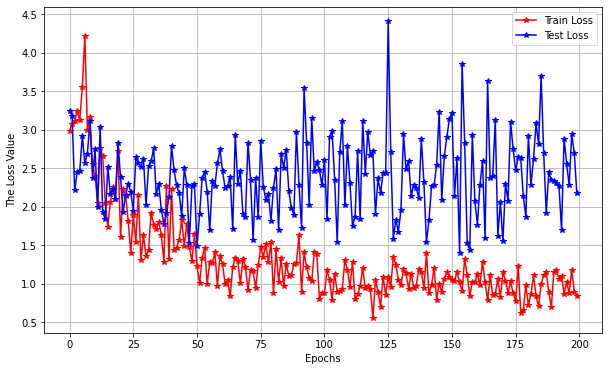

In [68]:
loss_plotter(train_losses,test_losses)